<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [20]:
df = pd.read_csv('datasets/SSE.csv')
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2020-01-01'
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2023-01-01'

In [23]:
df.head()


,tic,date,close,open,high,low,volume,day
0,000001.SH,2010-01-04,3243.760,3289.750,3295.279,3243.319,109447927.0,0
1,000001.SH,2010-01-05,3282.179,3254.468,3290.512,3221.462,126115066.0,1
2,000001.SH,2010-01-06,3254.215,3277.517,3295.868,3253.044,123651384.0,2
3,000001.SH,2010-01-07,3192.776,3253.991,3268.819,3176.707,128652827.0,3
4,000001.SH,2010-01-08,3195.997,3177.259,3198.920,3149.017,98377147.0,4


In [21]:
df.tail()

,tic,date,close,open,high,low,volume,day
3154,000001.SH,2022-12-26,3065.5626,3048.1963,3071.8363,3047.3491,206503893.0,0
3155,000001.SH,2022-12-27,3095.5678,3077.7469,3098.0783,3074.3133,222218322.0,1
3156,000001.SH,2022-12-28,3087.3997,3088.6174,3098.6496,3079.4338,224554151.0,2
3157,000001.SH,2022-12-29,3073.7016,3076.7264,3086.0048,3064.4594,215570676.0,3
3158,000001.SH,2022-12-30,3089.2579,3084.5226,3096.3135,3082.1964,217545344.0,4


In [22]:
df.shape

(3159, 8)

In [24]:
df.sort_values(['date','tic']).head()

,tic,date,close,open,high,low,volume,day
0,000001.SH,2010-01-04,3243.760,3289.750,3295.279,3243.319,109447927.0,0
1,000001.SH,2010-01-05,3282.179,3254.468,3290.512,3221.462,126115066.0,1
2,000001.SH,2010-01-06,3254.215,3277.517,3295.868,3253.044,123651384.0,2
3,000001.SH,2010-01-07,3192.776,3253.991,3268.819,3176.707,128652827.0,3
4,000001.SH,2010-01-08,3195.997,3177.259,3198.920,3149.017,98377147.0,4


In [25]:
len(df.tic.unique())

1

In [26]:
df.tic.value_counts()

000001.SH    3159
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [14]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [27]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [28]:
processed.sample(5)

,tic,date,close,open,high,low,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
2668,000001.SH,2020-12-24,3363.1133,3382.1930,3394.0746,3354.0215,275044450.0,3,4.190177,3462.534437,3330.785503,50.925673,-34.341448,2.918014,3385.588637,3338.645418,0.241720
1641,000001.SH,2016-10-11,3065.2500,3051.6220,3066.1040,3048.0180,167273496.0,1,-6.986147,3108.070898,2963.134502,54.022684,23.730125,1.563477,3049.064500,3039.967283,0.123140
3132,000001.SH,2022-11-24,3089.3096,3104.0955,3113.2392,3084.8554,267482928.0,3,13.316238,3185.697645,2921.784675,49.420382,71.664277,10.138710,3045.577060,3095.171467,0.034342
2705,000001.SH,2021-02-23,3636.3573,3617.7013,3672.1511,3617.7013,398873174.0,1,36.491141,3709.772349,3446.445521,58.347173,110.325529,22.975784,3576.424807,3490.881137,0.049234
2378,000001.SH,2019-10-18,2938.1413,2982.3417,2987.2035,2933.2424,149990678.0,4,6.258243,3035.775155,2897.970895,49.580521,-35.273646,6.741315,2970.227430,2919.968785,1.056592


In [29]:
# save
processed.to_csv('datasets/SSE_processed.csv',index=False)

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

考虑到自动股票交易任务的随机性和互动性，金融任务被建模为一个 **马尔科夫决策过程(MDP)** 问题。训练过程包括观察股票价格的变化，采取一种行动和奖励的计算，让代理人相应地调整其策略。通过与环境的互动，交易代理将随着时间的推移得出一个具有最大回报的交易策略。

我们的交易环境，基于OpenAI Gym框架，根据时间驱动的模拟原则，用真实的市场数据模拟真实的股票市场。

行动空间描述了代理人与环境互动的允许行动。通常情况下，动作a包括三个动作。{-1，0，1}，其中-1，0，1代表卖出，持有，和买入一股。另外，一个行动可以在多个股票上进行。我们使用一个行动空间{-k,...,-1,0,1,...,k}，其中k表示要购买的股票数量，-k表示要出售的股票数量。例如，"买入10股AAPL "或 "卖出10股AAPL "分别为10或-10。连续行动空间需要归一化为[-1，1]，因为政策是在高斯分布上定义的，需要归一化和对称。

In [30]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5    
}

Stock Dimension: 1, State Space: 11


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [31]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [32]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [33]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  12.035898307599208
======Model training from:  2010-01-01 to  2020-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
------------------------------------
| time/                 |          |
|    fps                | 309      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | -0.0105  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 2.6      |
|    reward             | 0.234732 |
|    std                | 0.992    |
|    value_loss         | 3.99     |
------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 363        |
| 

In [34]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2020-01-02,2020-04-09,DDPG,0.0,-0.275011,0.0
1,189,2020-04-09,2020-07-14,A2C,0.574128,0.196087,0.0
2,252,2020-07-14,2020-10-19,PPO,0.0,0.099247,-0.049828
3,315,2020-10-19,2021-01-15,A2C,0.271363,0.16121,0.0
4,378,2021-01-15,2021-04-22,A2C,0.200789,-0.183405,0.0
5,441,2021-04-22,2021-07-26,PPO,-0.362075,0.133616,0.0
6,504,2021-07-26,2021-11-01,DDPG,0.069436,-0.168896,0.159624
7,567,2021-11-01,2022-01-28,A2C,0.0,-0.179954,-0.151836
8,630,2022-01-28,2022-05-11,A2C,-0.226871,-0.486036,-0.406326
9,693,2022-05-11,2022-08-09,DDPG,0.0,-0.146013,0.0


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [35]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [36]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.09723914555432366


In [37]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.0,2020-04-09,NaN,2020-04-09
1,1000000.0,2020-04-10,0.0,2020-04-10
2,1000000.0,2020-04-13,0.0,2020-04-13
3,1000000.0,2020-04-14,0.0,2020-04-14
4,1000000.0,2020-04-15,0.0,2020-04-15


In [41]:
df_account_value.sample(5)

,account_value,date,daily_return,datadate
101,9.723657e+05,2020-09-04,-0.008725,2020-09-04
197,1.006487e+06,2021-01-27,0.001093,2021-01-27
473,9.655315e+05,2022-03-22,0.000000,2022-03-22
212,1.003885e+06,2021-02-24,-0.019830,2021-02-24
495,9.655315e+05,2022-04-25,0.000000,2022-04-25


<Axes: >

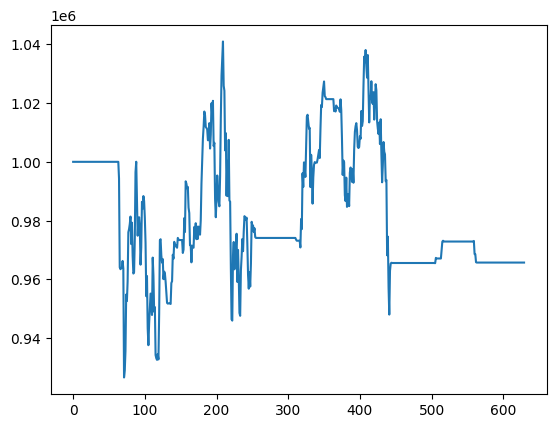

In [38]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [39]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.013872
Cumulative returns    -0.034321
Annual volatility      0.096228
Sharpe ratio          -0.097239
Calmar ratio          -0.151853
Stability              0.031083
Max drawdown          -0.091353
Omega ratio            0.975763
Sortino ratio         -0.132036
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.916057
Daily value at risk   -0.012161
dtype: float64


In [56]:
#baseline stats
print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

baseline_df = pd.read_csv('datasets/DJI.csv')

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
Annual return          0.047144
Cumulative returns     0.148203
Annual volatility      0.251668
Sharpe ratio           0.309868
Calmar ratio           0.127119
Stability              0.455733
Max drawdown          -0.370862
Omega ratio            1.064578
Sortino ratio          0.428345
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.947875
Daily value at risk   -0.031398
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

In [57]:
baseline_df

,date,open,high,low,close,volume,tic,day
0,2020-01-02,28638.970703,28872.800781,28627.769531,28868.800781,251820000,^DJI,3
1,2020-01-03,28553.330078,28716.310547,28500.359375,28634.880859,239590000,^DJI,4
2,2020-01-06,28465.500000,28708.019531,28418.630859,28703.380859,252760000,^DJI,0
3,2020-01-07,28639.179688,28685.500000,28565.279297,28583.679688,258900000,^DJI,1
4,2020-01-08,28556.140625,28866.179688,28522.509766,28745.089844,291750000,^DJI,2
...,...,...,...,...,...,...,...,...
751,2022-12-23,32961.058594,33226.140625,32814.019531,33203.929688,221050000,^DJI,4
752,2022-12-27,33224.230469,33387.718750,33069.578125,33241.558594,246010000,^DJI,1
753,2022-12-28,33264.761719,33379.550781,32869.148438,32875.710938,252260000,^DJI,2
754,2022-12-29,33021.429688,33293.421875,33020.351562,33220.800781,243060000,^DJI,3


In [67]:
import importlib
# from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
importlib.reload(sys.modules['finrl.plot'])
from finrl.plot import backtest_plot


In [64]:
# from copy import deepcopy
# import pyfolio
# from pyfolio import timeseries
# def backtest_plot(
#     account_value,
#     baseline_start=TRADE_START_DATE,
#     baseline_end=TRADE_END_DATE,
#     baseline_ticker="^DJI",
#     value_col_name="account_value",
#     baseline_df=None
# ):
#     df = deepcopy(account_value)
#     df["date"] = pd.to_datetime(df["date"])
#     test_returns = get_daily_return(df, value_col_name=value_col_name)
#     # if baseline_df == None:
#     #     baseline_df = get_baseline(
#     #         ticker=baseline_ticker, start=baseline_start, end=baseline_end
#     #     )

#     #     baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y-%m-%d")
#     #     baseline_df = pd.merge(df[["date"]], baseline_df, how="left", on="date")
#     #     baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
#     baseline_returns = get_daily_return(baseline_df, value_col_name="close")

#     with pyfolio.plotting.plotting_context(font_scale=1.1):
#         pyfolio.create_full_tear_sheet(
#             returns=test_returns, benchmark_rets=baseline_returns, set_context=False
#         )

==============Compare to DJIA===========


Start date,2020-04-09
End date,2022-11-11
Total months,30
,Backtest
Annual return,-1.387%
Cumulative returns,-3.432%
Annual volatility,9.623%
Sharpe ratio,-0.10
Calmar ratio,-0.15
Stability,0.03
Max drawdown,-9.135%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.14,2021-02-19,2021-03-10,NaT,NaN
1,7.35,2020-07-14,2020-07-24,2020-08-18,26
2,6.75,2020-08-18,2020-09-28,2021-01-04,100
3,3.89,2021-01-25,2021-01-29,2021-02-10,13
4,1.24,2021-01-07,2021-01-19,2021-01-21,11


Stress Events,mean,min,max
New Normal,-0.00%,-3.85%,2.63%


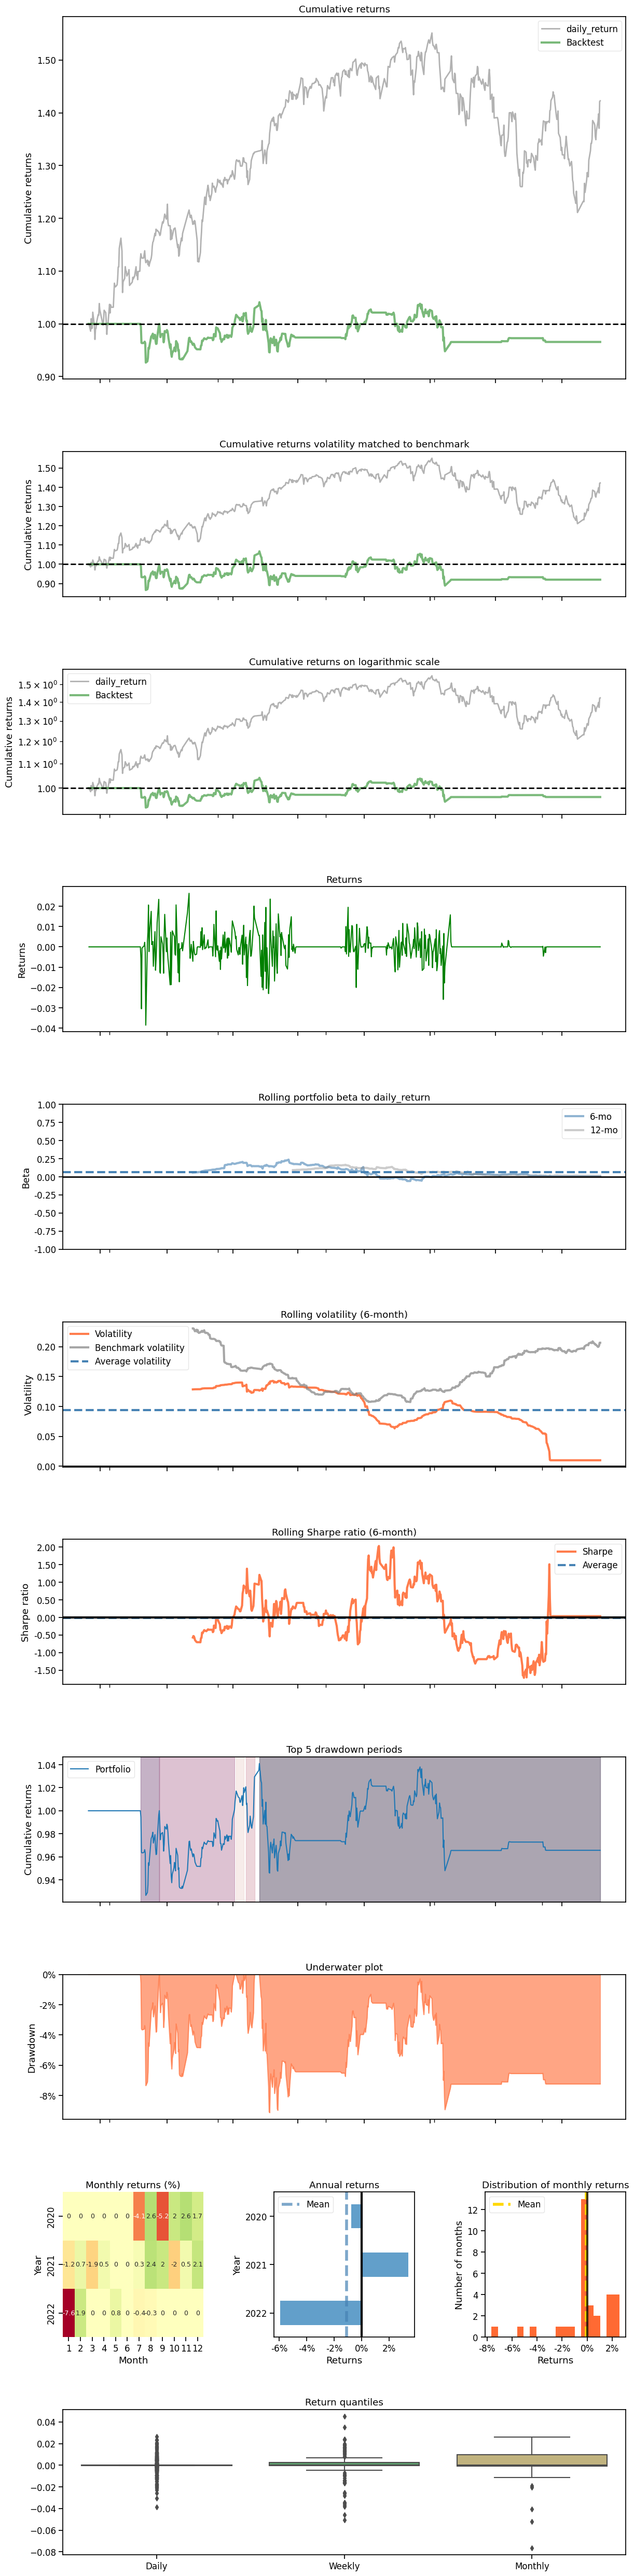

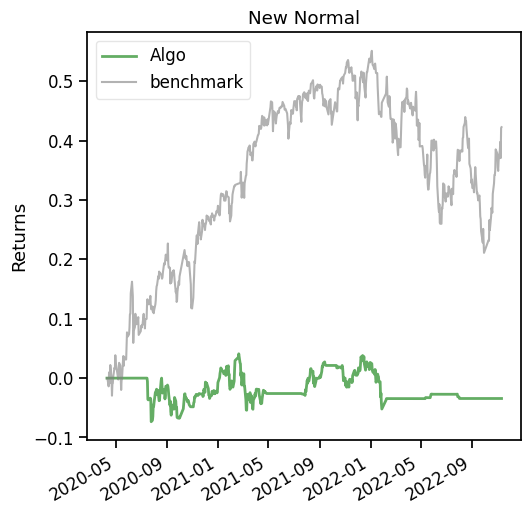

In [68]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'], baseline_df = baseline_df)